In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/all_data.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test_private_expanded.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/toxicity_individual_annotations.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/train.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/identity_individual_annotations.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test.csv


In [2]:

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tqdm import tqdm
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix,classification_report
%matplotlib inline
warnings.filterwarnings("ignore")
from IPython.display import Image,HTML

#KERAS Import
from keras.models import Sequential, Model
from keras.utils import to_categorical,plot_model
from keras.layers import Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.layers import Embedding, LSTM, Flatten, Input, add
from keras.regularizers import l2
from keras.optimizers import Adam

from keras import backend as K
from keras.engine.topology import Layer
from keras import regularizers, optimizers, layers

In [3]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [4]:
df = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv', nrows=120000)
print(mem_usage(df))
df.head()


100.22 MB


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [5]:
test_df = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

### Data Cleaning

In [6]:
print(df.iloc[12]['comment_text'])
print("Toxicity Level: ",df.iloc[12]['target'])

This seems like a step in the right direction.
Toxicity Level:  0.0


In [7]:
print(df.iloc[2]['comment_text'])
print("Toxicity Level: ",df.iloc[2]['target'])

This is such an urgent design problem; kudos to you for taking it on. Very impressive!
Toxicity Level:  0.0


In [8]:
# Text preprocessing
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [10]:
# Combining all the above statemennts 
preprocessed_comments = []
# tqdm is for printing the status bar
for sentence in tqdm(df['comment_text'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() )
    preprocessed_comments.append(sent.lower().strip())

100%|██████████| 120000/120000 [00:06<00:00, 17446.23it/s]


In [11]:
df['comment_text'][2]

'This is such an urgent design problem; kudos to you for taking it on. Very impressive!'

In [12]:
# Combining all the above statemennts on test
preprocessed_comments_test = []
# tqdm is for printing the status bar
for sentence in tqdm(test_df['comment_text'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split())
    preprocessed_comments_test.append(sent.lower().strip())

100%|██████████| 97320/97320 [00:05<00:00, 18080.61it/s]


In [13]:
test_df['comment_text'] = preprocessed_comments_test

### Exploratory Data Analysis

<p>Percentage of NaN values</p>

In [14]:
train_len = len(df.index)

In [15]:
miss_val_train_df = df.isnull().sum(axis=0) / train_len
miss_val_train_df = miss_val_train_df[miss_val_train_df > 0] * 100
miss_val_train_df

asian                                  80.372500
atheist                                80.372500
bisexual                               80.372500
black                                  80.372500
buddhist                               80.372500
christian                              80.372500
female                                 80.372500
heterosexual                           80.372500
hindu                                  80.372500
homosexual_gay_or_lesbian              80.372500
intellectual_or_learning_disability    80.372500
jewish                                 80.372500
latino                                 80.372500
male                                   80.372500
muslim                                 80.372500
other_disability                       80.372500
other_gender                           80.372500
other_race_or_ethnicity                80.372500
other_religion                         80.372500
other_sexual_orientation               80.372500
physical_disability 

### Distribution Plot

In [16]:
def plot_features_distribution(features, title):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        # This will find all the values which are not null so as to plot the ditribution
        sns.distplot(df.loc[~df[feature].isnull(),feature],kde=True,hist=False, bins=120, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

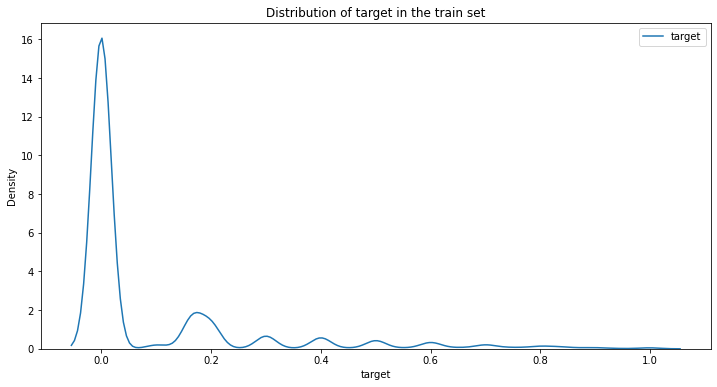

In [17]:
# Distribution of target variable
plt.figure(figsize=(12,6))
plt.title("Distribution of target in the train set")
sns.distplot(df['target'],kde=True,hist=False, bins=120, label='target')
plt.legend()
plt.show()

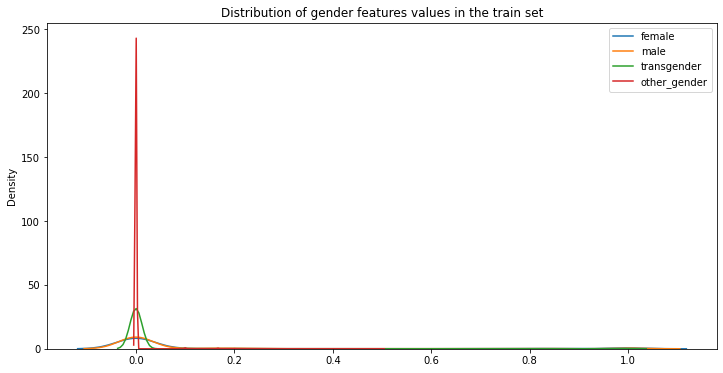

In [18]:
features = ['female', 'male', 'transgender', 'other_gender']
plot_features_distribution(features, "Distribution of gender features values in the train set")

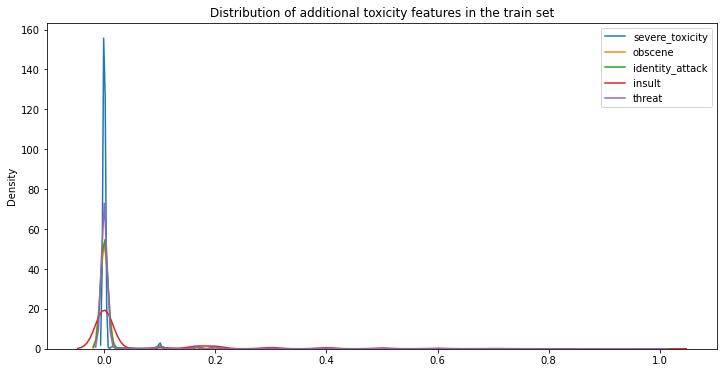

In [19]:
features = ['severe_toxicity', 'obscene','identity_attack','insult','threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set")

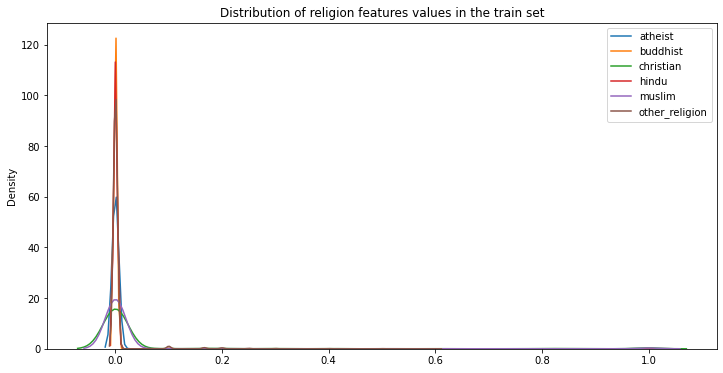

In [20]:
features = ['atheist','buddhist','christian', 'hindu', 'muslim', 'other_religion']
plot_features_distribution(features, "Distribution of religion features values in the train set")

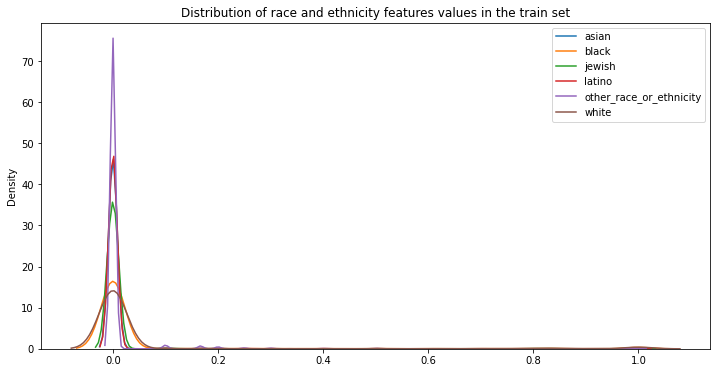

In [21]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_features_distribution(features, "Distribution of race and ethnicity features values in the train set")

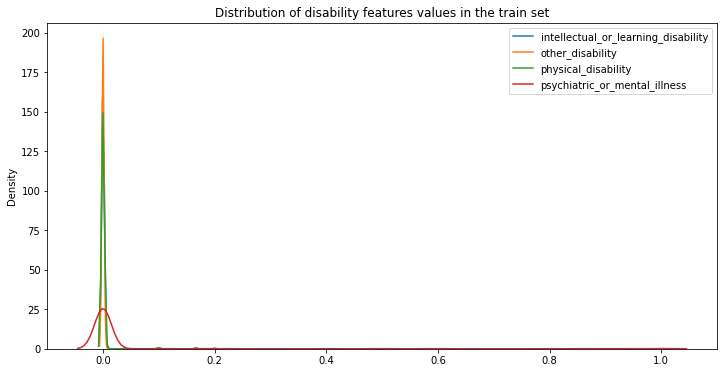

In [22]:
features = ['intellectual_or_learning_disability', 'other_disability', 'physical_disability', 'psychiatric_or_mental_illness']
plot_features_distribution(features, "Distribution of disability features values in the train set")

* Values which are less that 0.5 are non- toxic and greater than 0.5 are toxic
* There are lot of values where the target value is 0 and fewer values near to 1.
* There are a lot of "Female" associated word.
* Religions like "Muslim" and "Christanity" are on the higher numbers.

## Word Cloud
<p>To see frequent words used for different categories</p>

In [23]:
def make_wordcloud(comment_words,title):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
              min_font_size = 10,random_state=101,repeat=True).generate(str(comment_words)) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.title(title)
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

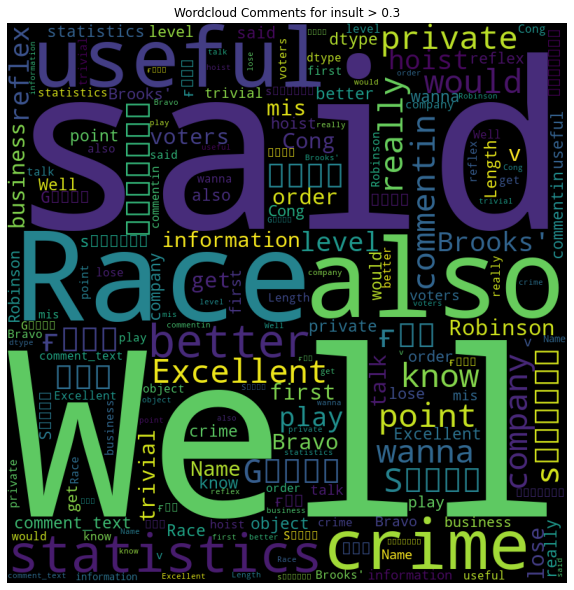

In [24]:
make_wordcloud(df.loc[df['insult'] < 0.3]['comment_text'].sample(10000),title='Wordcloud Comments for insult > 0.3')

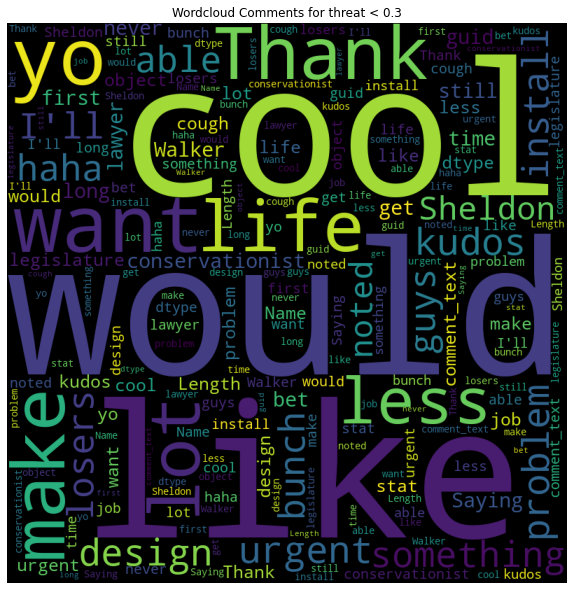

In [25]:
make_wordcloud(df.loc[df['threat'] < 0.3]['comment_text'],title='Wordcloud Comments for threat < 0.3')

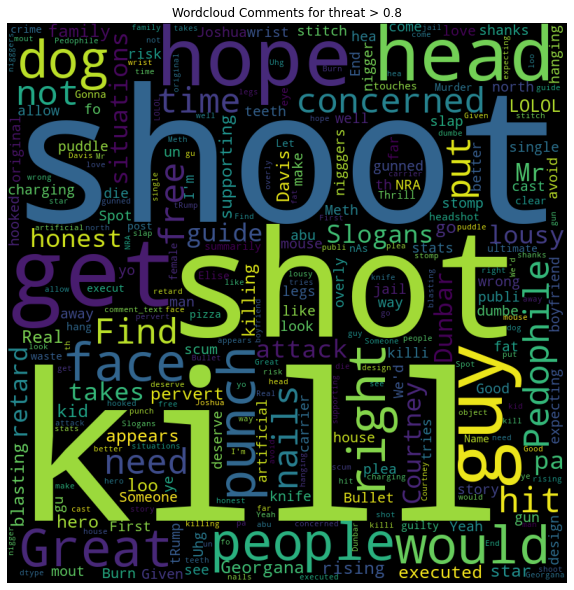

In [26]:
make_wordcloud(df.loc[df['threat'] > 0.8]['comment_text'],title='Wordcloud Comments for threat > 0.8')

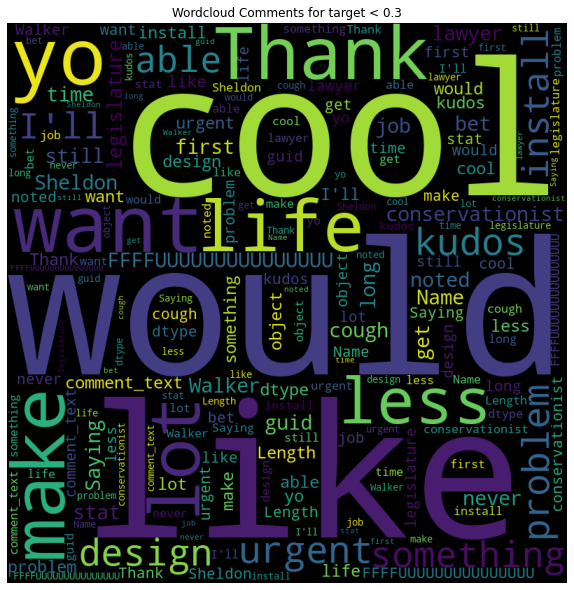

In [27]:
make_wordcloud(df.loc[df['target'] < 0.3]['comment_text'],title='Wordcloud Comments for target < 0.3')

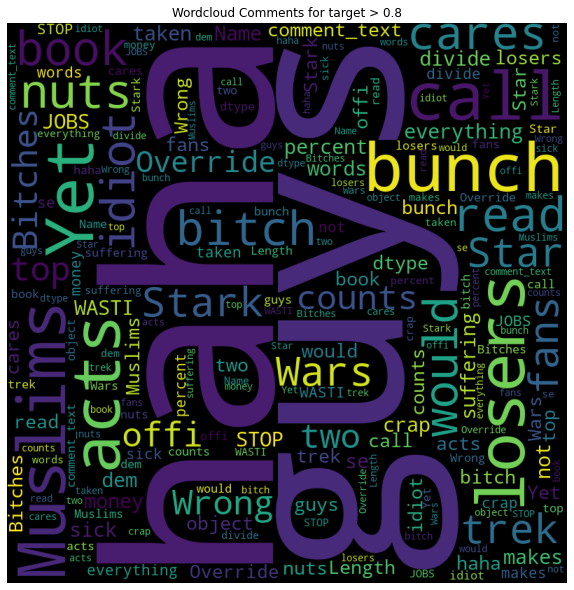

In [28]:
make_wordcloud(df.loc[df['target'] > 0.8]['comment_text'],title='Wordcloud Comments for target > 0.8')

In [29]:
identity_columns = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

In [30]:
for column in identity_columns + ['target']:
    df[column] = np.where(df[column] >= 0.5, True, False)

In [31]:
# Target variable as well
y = df['target'].values

#### We will use tfidf and w2v to vectorize the words

### Data Splitting

In [32]:
train_df, cv_df, y_train, y_cv = train_test_split(df, y, test_size=0.2, random_state=42)

In [33]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

In [34]:
train_tfidf = vectorizer.fit_transform(train_df["comment_text"])
cv_tfidf = vectorizer.transform(cv_df["comment_text"])
test_tfidf = vectorizer.transform(test_df["comment_text"])

In [35]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,4), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix,index=class_names, columns=class_names
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [36]:
def threshold_based_prediction(proba,threshold,tpr,fpr):
    thres = threshold[np.argmax(fpr*(1-tpr))]
    predictions = []
    for i in proba:
        if i>=thres:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [37]:
import gc
del df
gc.collect()


33344

## Logistic Regression model

Using TFIDF vectorized data

In [38]:
alpha = [10 ** x for x in range(-5, 2)]
auc_array_train=[]
auc_array_cv=[]
for i in alpha:
  clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=5,class_weight='balanced')
  clf.fit(train_tfidf, y_train)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(train_tfidf, y_train)
    
    
  predict_y_train = sig_clf.predict_proba(train_tfidf)[:,1]
  predict_y = sig_clf.predict_proba(cv_tfidf)[:,1]
  auc_array_train.append(roc_auc_score(y_train, predict_y_train))
  auc_array_cv.append(roc_auc_score(y_cv, predict_y))
  print('For values of alpha = ', i, "The auc score on CV is:",roc_auc_score(y_cv, predict_y))

For values of alpha =  1e-05 The auc score on CV is: 0.913828776076116
For values of alpha =  0.0001 The auc score on CV is: 0.8836123393385894
For values of alpha =  0.001 The auc score on CV is: 0.8372071787132568
For values of alpha =  0.01 The auc score on CV is: 0.8162267368662263
For values of alpha =  0.1 The auc score on CV is: 0.807931254343013
For values of alpha =  1 The auc score on CV is: 0.809450242902604
For values of alpha =  10 The auc score on CV is: 0.8131756951772386


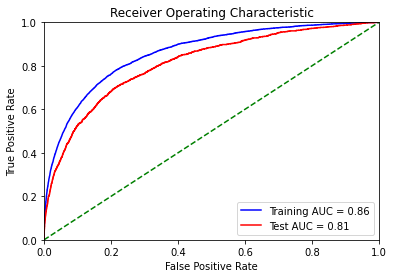

In [39]:
fpr_train, tpr_train, threshold_train = roc_curve(y_train, predict_y_train)
fpr_test, tpr_test, threshold_test = roc_curve(y_cv, predict_y)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)


plt.title('Receiver Operating Characteristic')

plt.plot(fpr_train, tpr_train, 'b', label = 'Training AUC = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'r', label = 'Test AUC = %0.2f' % roc_auc_test)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [40]:
clf = SGDClassifier(alpha=0.00001, penalty='l2', loss='log', random_state=42,class_weight='balanced')
clf.fit(train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_tfidf, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-05,
                                                    class_weight='balanced',
                                                    loss='log',
                                                    random_state=42))

In [41]:
predtrain = sig_clf.predict_proba(train_tfidf)[:,1]
predcv = sig_clf.predict_proba(cv_tfidf)[:,1]
pred = sig_clf.predict_proba(test_tfidf)[:,1]

	TRAIN DATA CONFUSION MATRIX


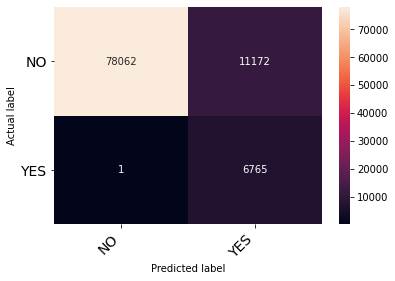

In [42]:
predtrain = threshold_based_prediction(predtrain,threshold_train,tpr_train,fpr_train)
cm = confusion_matrix(y_train, predtrain)
print("\tTRAIN DATA CONFUSION MATRIX")
print_confusion_matrix(cm,class_names=['NO','YES'])

	TEST DATA CONFUSION MATRIX


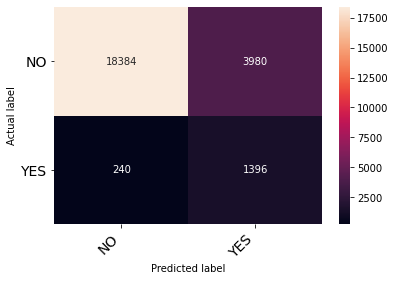

In [43]:
predcv = threshold_based_prediction(predcv,threshold_test,tpr_test,fpr_test)
cm = confusion_matrix(y_cv, predcv)
print("\tTEST DATA CONFUSION MATRIX")
print_confusion_matrix(cm,class_names=['NO','YES'])

### AUC Score

* Train data

In [44]:
auc = roc_auc_score(y_train, predtrain)
print('\nTRAIN AUC on CV data is %f' % (auc))


TRAIN AUC on CV data is 0.937327


* Test data

In [45]:
auc = roc_auc_score(y_cv, predcv)
print('\nTEST AUC on CV data is %f' % (auc))


TEST AUC on CV data is 0.837668


#### F1 Score

In [46]:
print(classification_report(y_cv,predcv))

              precision    recall  f1-score   support

       False       0.99      0.82      0.90     22364
        True       0.26      0.85      0.40      1636

    accuracy                           0.82     24000
   macro avg       0.62      0.84      0.65     24000
weighted avg       0.94      0.82      0.86     24000



Conclusion
* With Logistic regression we are seeing that the model is slightly overfitting on the train data
* It is not doing very good against the unintended bias that we are trying to avoid
* A lot of comments that are usually not toxic has been classified as toxic by our model by looking at the confusion matrix


In [47]:
del train_tfidf
gc.collect()

12963

In [48]:
del test_tfidf
gc.collect()

22

In [49]:
del cv_tfidf
gc.collect()

22

### Recurrent Neural Network

#### Metrics definition

In [50]:
# https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/90986#latest-527331
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive
TOXICITY_COLUMN = 'target'

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

In [51]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

#### Using LSTM - Single LSTM layer architecture


Preparing the text data for model

In [52]:
MAX_VOCAB_SIZE = 100000
TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'
MAX_SEQUENCE_LENGTH = 300

# Create a text tokenizer.
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(train_df[TEXT_COLUMN])

# All comments must be truncated or padded to be the same length.
def padding_text(texts, tokenizer):
    return sequence.pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)

In [53]:
train_text = padding_text(train_df[TEXT_COLUMN], tokenizer)
train_y = to_categorical(train_df[TOXICITY_COLUMN])
validate_text = padding_text(cv_df[TEXT_COLUMN], tokenizer)
validate_y = to_categorical(cv_df[TOXICITY_COLUMN])

In [54]:
# for submission purpose
test_text = padding_text(test_df[TEXT_COLUMN], tokenizer)

In [55]:
NUM_EPOCHS = 5
BATCH_SIZE = 512

In [56]:
# https://fasttext.cc/docs/en/english-vectors.html
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip

--2021-07-02 01:43:34--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  30.0MB/s    in 67s     

2021-07-02 01:44:42 (21.6 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [57]:
!unzip crawl*.zip

Archive:  crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


#### Creating the embedding matrix for the embedding layer

In [58]:
embeddings_index = {}
with open('crawl-300d-2M.vec' ,encoding='utf8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [59]:
len(tokenizer.word_index)

78654

In [60]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1,300))
num_words_in_embedding = 0
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    num_words_in_embedding += 1
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector

In [61]:
embedding_matrix.shape

(78655, 300)

#### Model building


In [62]:
input_text_lstm = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedding_layer_lstm = Embedding(len(tokenizer.word_index) + 1,
                                    300,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
l = embedding_layer_lstm(input_text_lstm)
l = LSTM(128,return_sequences=True,dropout=0.5,kernel_regularizer=l2(0.001))(l)
l = Flatten()(l)
l = Dropout(0.5)(l)
l = Dense(128, activation='relu')(l)
lstm_output = Dense(2, activation='softmax')(l)

In [63]:
model = Model(inputs=[input_text_lstm], outputs=[lstm_output])

#### Model Visualization

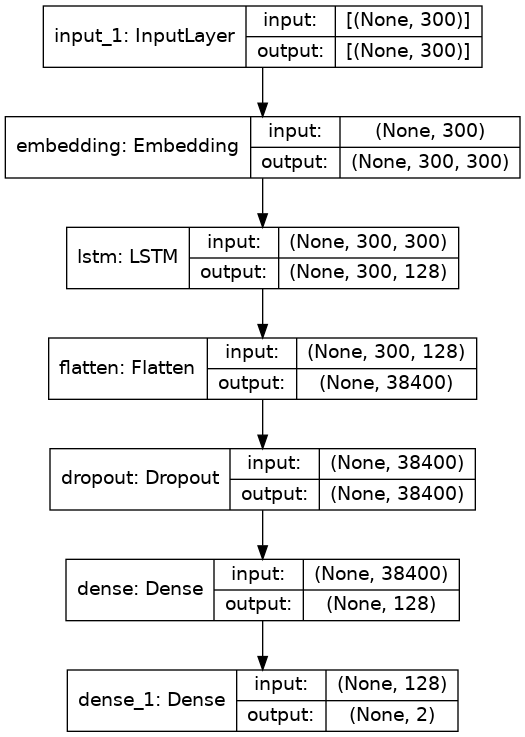

In [64]:
plot_model(model, show_shapes=True, to_file='singlelstm.png')
Image(filename="singlelstm.png")

#### Model training

In [65]:
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [66]:
SLSTM_Model = model.fit(train_text,train_y,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(validate_text, validate_y))

Epoch 1/5
188/188 [==============================] - 619s 3s/step - loss: 0.4317 - accuracy: 0.9179 - val_loss: 0.2026 - val_accuracy: 0.9378
Epoch 2/5
188/188 [==============================] - 619s 3s/step - loss: 0.2056 - accuracy: 0.9375 - val_loss: 0.1800 - val_accuracy: 0.9445
Epoch 3/5
188/188 [==============================] - 617s 3s/step - loss: 0.1797 - accuracy: 0.9418 - val_loss: 0.1639 - val_accuracy: 0.9466
Epoch 4/5
188/188 [==============================] - 625s 3s/step - loss: 0.1741 - accuracy: 0.9430 - val_loss: 0.1579 - val_accuracy: 0.9467
Epoch 5/5
188/188 [==============================] - 625s 3s/step - loss: 0.1696 - accuracy: 0.9433 - val_loss: 0.1680 - val_accuracy: 0.9463


#### Result

In [67]:
# Prediction on CV data
MODEL_NAME = 'slstm_model'
cv_df[MODEL_NAME] = model.predict(validate_text)[:, 1]

In [68]:
bias_metrics_df = compute_bias_metrics_for_model(cv_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
7,white,245,0.794163,0.814219,0.934066
5,muslim,125,0.799942,0.785968,0.943743
2,homosexual_gay_or_lesbian,168,0.801114,0.813486,0.940006
6,black,194,0.818494,0.832194,0.930325
0,male,516,0.828727,0.848002,0.932933
1,female,606,0.854984,0.866091,0.932484
8,psychiatric_or_mental_illness,102,0.869512,0.908431,0.905161
4,jewish,39,0.888235,0.860245,0.945858
3,christian,198,0.912965,0.858067,0.960716


In [69]:
get_final_metric(bias_metrics_df, calculate_overall_auc(cv_df, MODEL_NAME))

0.8843489283694113

#### Observation
1. Better results with just a single LSTM layer.
3. We obtain a good score of 0.8843489283694113

## Conclusion

In [71]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "AUC/Designed Metrics AUC"]

x.add_row(["Logistic Regression:", 0.837668])
x.add_row(["Single LSTM:", 0.884349])

print(x)

+----------------------+--------------------------+
|        Model         | AUC/Designed Metrics AUC |
+----------------------+--------------------------+
| Logistic Regression: |         0.837668         |
|     Single LSTM:     |         0.884349         |
+----------------------+--------------------------+
